# 02 — EDA and preprocessing of UniProt protein family dataset

In this notebook we perform **exploratory data analysis (EDA)** and basic **preprocessing**
of the raw protein family dataset built in `01_build_dataset.ipynb`.

The goals of this step:

1. **Inspect the raw dataset**
   - Check class balance (`family` distribution)
   - Explore sequence length distributions by family
   - Inspect organism diversity within each family
   - Detect potential issues (strange characters, duplicated patterns, etc.)

2. **Mitigate obvious sampling biases**
   - Optionally limit the contribution of any single organism per family
     (e.g. to avoid a class consisting almost entirely of one species)
   - Ensure that families are not trivially equivalent to a single organism

3. **Prepare a cleaned, analysis-ready dataset**
   - Remove problematic entries (invalid characters, suspicious sequences)
   - Apply organism-level downsampling if needed
   - Save the cleaned dataset for downstream use:

   ```text
   data/processed/
       protein
This notebook bridges the gap between raw UniProt exports and the embedding/modeling stages:

- 03_esm_embeddings.ipynb will consume the cleaned dataset and compute ESM-1b embeddings.

- 04_train_and_eval.ipynb will train and evaluate the classifiers.

- 05_interpret_and_visualize.ipynb will focus on UMAP/SHAP and per-protein case studies._families_full_clean.csv


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from Bio import pairwise2
from itertools import combinations
from pathlib import Path


PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.config import RAW_DIR, PROCESSED_DIR, FAMILY_KEYWORDS

In [9]:
raw_path = RAW_DIR / "protein_families_small.csv"
df_raw = pd.read_csv(raw_path)

print(df_raw.head())
print(df_raw.shape)
print(df_raw["family"].value_counts())

  uniprot_id                                       protein_name  \
0     O00444  Serine/threonine-protein kinase PLK4 (EC 2.7.1...   
1     O00506  Serine/threonine-protein kinase 25 (EC 2.7.11....   
2     O00746  Nucleoside diphosphate kinase, mitochondrial (...   
3     O14757  Serine/threonine-protein kinase Chk1 (EC 2.7.1...   
4     O15111  Inhibitor of nuclear factor kappa-B kinase sub...   

               organism  length  \
0  Homo sapiens (Human)     970   
1  Homo sapiens (Human)     426   
2  Homo sapiens (Human)     187   
3  Homo sapiens (Human)     476   
4  Homo sapiens (Human)     745   

                                            sequence  family  
0  MATCIGEKIEDFKVGNLLGKGSFAGVYRAESIHTGLEVAIKMIDKK...  kinase  
1  MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVV...  kinase  
2  MGGLFWRSALRGLRCGPRAPGPSLLVRHGSGGPSWTRERTLVAVKP...  kinase  
3  MAVPFVEDWDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDMKRAV...  kinase  
4  MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...  kinase  
(4264, 6

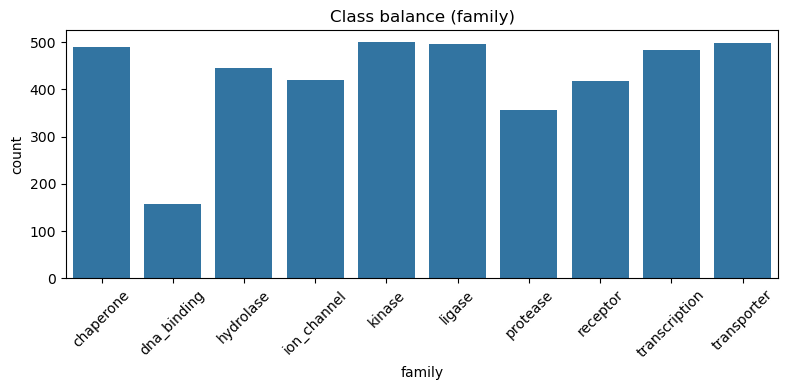

In [10]:
plt.figure(figsize=(8, 4))
sns.countplot(
    data=df_clean,
    x="family",
    order=sorted(df_clean["family"].unique())
)
plt.title("Class balance (family)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# какие символы вообще встречаются в последовательностях?
unique_chars = sorted(set("".join(df_raw["sequence"].tolist())))
unique_chars

['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y']

In [5]:
allowed = set("ACDEFGHIKLMNPQRSTVWYXBZU")

def is_valid_seq(s: str) -> bool:
    return all(c in allowed for c in s)

mask_valid = df_raw["sequence"].apply(is_valid_seq)
df_clean = df_raw[mask_valid].copy()

print("Invalid sequences removed:", (~mask_valid).sum())

Invalid sequences removed: 0


In [6]:
df_clean.groupby("family")["organism"].nunique()

family
chaperone        11
dna_binding       1
hydrolase         1
ion_channel      10
kinase            8
ligase           61
protease         12
receptor          1
transcription     1
transporter       1
Name: organism, dtype: int64

In [7]:
top_org = (
    df_clean.groupby(["family", "organism"])
            .size()
            .reset_index(name="count")
)

top_org.sort_values(["family", "count"], ascending=[True, False]).groupby("family").head(5)

,family,organism,count
6,chaperone,Homo sapiens (Human),180
7,chaperone,Mus musculus (Mouse),70
0,chaperone,Arabidopsis thaliana (Mouse-ear cress),62
10,chaperone,Saccharomyces cerevisiae (strain ATCC 204508 /...,60
9,chaperone,Rattus norvegicus (Rat),43
11,dna_binding,Homo sapiens (Human),157
12,hydrolase,Homo sapiens (Human),445
19,ion_channel,Homo sapiens (Human),182
20,ion_channel,Mus musculus (Mouse),84
21,ion_channel,Rattus norvegicus (Rat),77


In [11]:
print(df_clean["length"].describe())
df_clean.groupby("family")["length"].describe()

count    4264.000000
mean      493.312148
std       217.393913
min        51.000000
25%       333.000000
50%       471.000000
75%       639.000000
max       999.000000
Name: length, dtype: float64


,count,mean,std,min,25%,50%,75%,max
family,,,,,,,,
chaperone,490.0,405.426531,211.151909,63.0,222.25,379.0,548.75,999.0
dna_binding,157.0,420.828025,235.050572,81.0,229.00,372.0,575.00,976.0
hydrolase,445.0,496.011236,211.696669,140.0,335.00,471.0,628.00,991.0
ion_channel,420.0,550.835714,206.967960,123.0,422.00,505.0,677.00,997.0
kinase,500.0,562.120000,204.091244,152.0,413.75,527.0,713.00,999.0
ligase,495.0,573.319192,179.079561,100.0,453.00,566.0,694.00,985.0
protease,356.0,535.494382,223.916301,110.0,352.00,488.5,725.25,990.0
receptor,418.0,449.751196,195.853749,129.0,326.00,384.0,536.00,984.0
transcription,484.0,449.863636,202.191846,58.0,300.50,425.5,574.25,993.0


<Figure size 800x500 with 0 Axes>

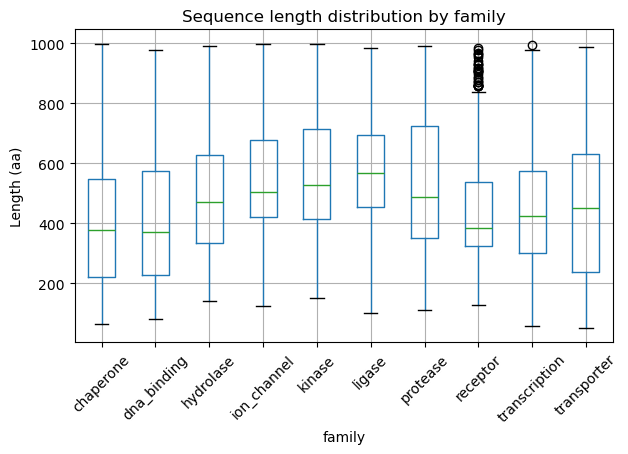

In [12]:
plt.figure(figsize=(8, 5))
df_clean.boxplot(column="length", by="family")
plt.title("Sequence length distribution by family")
plt.suptitle("")
plt.ylabel("Length (aa)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
org_counts = (
    df_clean.groupby(["family", "organism"])
            .size()
            .reset_index(name="count")
)

# доля самого частого организма в каждом семействе
top_org_fraction = (
    org_counts
    .sort_values(["family", "count"], ascending=[True, False])
    .groupby("family")
    .apply(lambda g: g["count"].iloc[0] / g["count"].sum())
    .rename("top_org_fraction")
)

top_org_fraction

C:\Users\555\AppData\Local\Temp\ipykernel_15320\312185781.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["count"].iloc[0] / g["count"].sum())


family
chaperone        0.367347
dna_binding      1.000000
hydrolase        1.000000
ion_channel      0.433333
kinase           0.952000
ligase           0.208081
protease         0.705056
receptor         1.000000
transcription    1.000000
transporter      1.000000
Name: top_org_fraction, dtype: float64

In [14]:
def mean_pairwise_identity(seqs, n_pairs=50, random_state=42):
    rng = np.random.default_rng(random_state)

    pairs = list(combinations(range(len(seqs)), 2))
    if len(pairs) > n_pairs:
        idx = rng.choice(len(pairs), size=n_pairs, replace=False)
        pairs = [pairs[i] for i in idx]

    idents = []
    for i, j in pairs:
        s1, s2 = seqs[i], seqs[j]
        # globalxx -> score = число совпадающих позиций
        score = pairwise2.align.globalxx(
            s1, s2, one_alignment_only=True, score_only=True
        )
        max_len = max(len(s1), len(s2))
        idents.append(score / max_len)
    return float(np.mean(idents))

for fam in df_clean["family"].unique():
    # берём до 50 последовательностей на семейство
    seqs_sample = (
        df_clean.loc[df_clean["family"] == fam, "sequence"]
        .sample(min(50, (df_clean["family"] == fam).sum()), random_state=42)
        .tolist()
    )
    mean_id = mean_pairwise_identity(seqs_sample, n_pairs=50)
    print(f"{fam:15s} mean pairwise identity (sample): {mean_id:.3f}")

D:\Anaconda\envs\esm_env\lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


kinase          mean pairwise identity (sample): 0.310
transporter     mean pairwise identity (sample): 0.243
ion_channel     mean pairwise identity (sample): 0.294
transcription   mean pairwise identity (sample): 0.283
chaperone       mean pairwise identity (sample): 0.279
receptor        mean pairwise identity (sample): 0.286
hydrolase       mean pairwise identity (sample): 0.295
ligase          mean pairwise identity (sample): 0.309
dna_binding     mean pairwise identity (sample): 0.272
protease        mean pairwise identity (sample): 0.268


In [15]:
out_path = PROCESSED_DIR / "protein_families_small_clean.csv"
df_clean.to_csv(out_path, index=False)
out_path, df_clean.shape

(WindowsPath('D:/ML/BioML/ESM/data/processed/protein_families_small_clean.csv'),
 (4264, 6))

# 02 — Exploratory Data Analysis (EDA) and Dataset Cleaning

This notebook performs exploratory analysis and sanity checks for the raw UniProt
dataset created in `01_build_dataset.ipynb`.

The goals of this step:

### 1. Inspect raw data
- Load the initial UniProt dataset from `data/raw/`.
- Verify class distribution across protein families.
- Inspect organism composition for every family (to detect class–species bias).
- Check for invalid or unexpected amino acid characters in sequences.

### 2. Basic cleaning
- Remove sequences containing non-standard characters.
- Optionally adjust or inspect class balance.

### 3. Prepare a clean dataset for embedding
After inspection and cleaning, the processed dat**data/processed/protein_families_small_clean.csv**a
This dataset is now ready for the next stage:

### → `03_esm_embeddings.ipynb`
where ESM-1b embeddings will be computed and saved as reproducible `.npy` + metadata.

No modeling, no visualization, and no embedding happens here —  
**this notebook focuses only on data quality and dataset readiness**.set is saved to:

